In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from aind_analysis_arch_result_access.han_pipeline import get_session_table
from aind_analysis_arch_result_access.util.s3 import get_s3_pkl, get_s3_json

In [8]:
S3_ROOT = "s3://aind-behavior-data/foraging_nwb_bonsai_processed/"

def get_s3_logistic_regression(subject_id, session_date, nwb_suffix):
    session_path = subject_id + "_" + session_date + "_" + str(nwb_suffix) + "/"
    df_logistic = get_s3_pkl(S3_ROOT + session_path + subject_id + "_" + session_date + "_" + str(nwb_suffix) + "_df_session_logistic_regression_df_beta_Su2022.pkl")
    return df_logistic

def get_s3_logistic_regression_batch(subject_ids, session_dates, nwb_suffixs, max_threads_for_s3=10):
    """Get df_logistic_betas from s3 for a batch of sessions"""
    with ThreadPoolExecutor(max_workers=max_threads_for_s3) as executor:
        results = list(
            tqdm(
                executor.map(get_s3_logistic_regression, subject_ids, session_dates, nwb_suffixs),
                total=len(subject_ids),
                desc="Get logistic regression betas from s3",
            )
        )
    return pd.concat(results).reset_index()

In [34]:
def plot_logistic_regression_non_photostim(df_all, max_trials_back=10, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200,
                               gridspec_kw=dict(bottom=0.2, top=0.9))
        
    xx = np.arange(1, max_trials_back + 1)
    
    plot_spec = {'RewC': ('tab:green', 'reward choices'), 
                 'UnrC': ('tab:red', 'unrewarded choices'), 
                 'bias': ('k', 'right bias')}    

    for name, (col, label) in plot_spec.items():
        
        if name == "bias":
            means = df_all[name].mean()
            cis = df_all[name].sem() * 1.96
        else:
            means = [df_all[name][t].mean() 
                    for t in xx]
            cis = [df_all[name][t].sem() * 1.96 
                   for t in xx]
                
        ax.errorbar(x=1 if name == 'bias' else xx,
                    y=means,
                    yerr=cis,
                    ls='-', 
                    marker='o',
                    color=col, 
                    capsize=5, markeredgewidth=1,
                    label=label + ' $\pm$95% CI')
    
    ax.set(xlabel='Past trials', ylabel='Logistic regression coeffs')
    ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
    ax.set(xticks=[1, 5, 10])

    n_mice = df_all['subject_id'].nunique()
    n_sessions = df_all.groupby(['subject_id', 'session_date']).ngroups
    ax.set(title=f'{n_mice} mice, {n_sessions} sessions')
    ax.set(ylim=[-0.1, 2.0])
    
    return ax

In [5]:
df = get_session_table()

In [37]:
stage_order = [
    "STAGE_1_WARMUP",
    "STAGE_1",
    "STAGE_2",
    "STAGE_3",
    "STAGE_4",
    "STAGE_FINAL",
    "GRADUATED",
]

df_logistic_all = dict()

for stage in stage_order:
    df_filtered = df.query(f"current_stage_actual == '{stage}' and curriculum_name == 'Uncoupled Without Baiting'")
    df_logistic_all[stage] = get_s3_logistic_regression_batch(
        df_filtered["subject_id"],
        df_filtered["session_date"].astype(str),
        df_filtered["nwb_suffix"],
        max_threads_for_s3=100,
    )


Get logistic regression betas from s3: 100%|██████████| 317/317 [00:02<00:00, 154.76it/s]


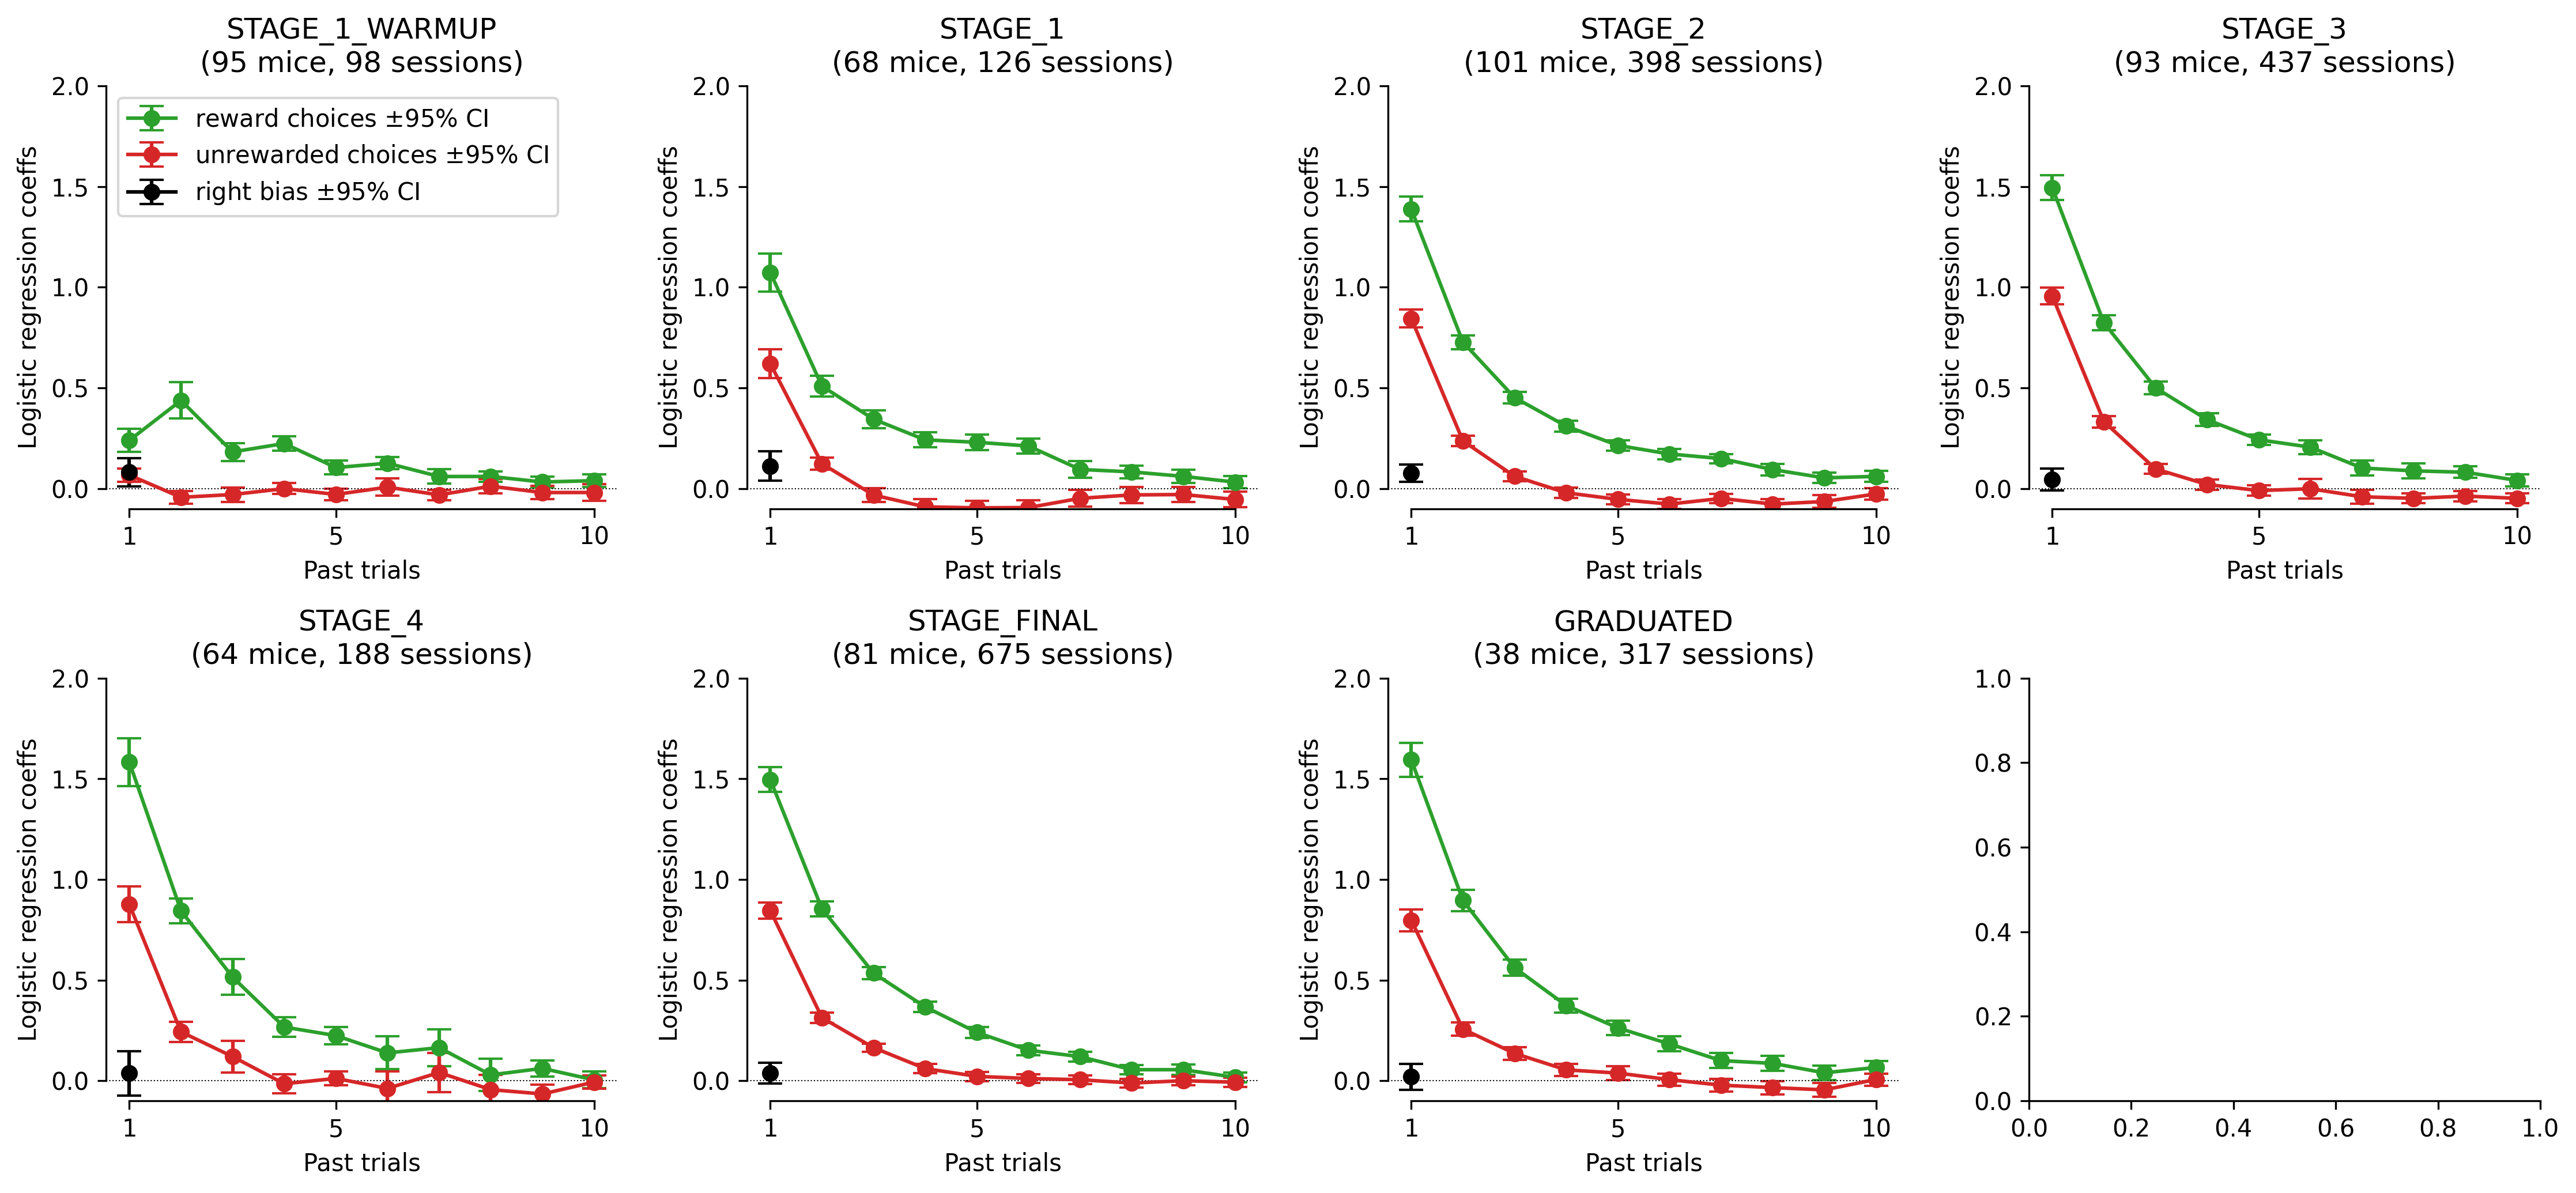

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7), dpi=300)

for stage in stage_order: 
    ax = axes.flatten()[stage_order.index(stage)]
    plot_logistic_regression_non_photostim(df_logistic_all[stage], ax=ax)
    
    if stage == "STAGE_1_WARMUP":
        ax.legend(loc='upper left')
    ax.set(title=f"{stage}\n({ax.get_title()})")

sns.despine(trim=True)
fig.tight_layout()